<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#需求背景" data-toc-modified-id="需求背景-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>需求背景</a></span></li><li><span><a href="#相关库导入" data-toc-modified-id="相关库导入-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>相关库导入</a></span></li><li><span><a href="#数据处理" data-toc-modified-id="数据处理-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>数据处理</a></span><ul class="toc-item"><li><span><a href="#数据导入" data-toc-modified-id="数据导入-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>数据导入</a></span><ul class="toc-item"><li><span><a href="#起始工作点获取" data-toc-modified-id="起始工作点获取-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>起始工作点获取</a></span></li></ul></li></ul></li><li><span><a href="#fastdtw计算曲线相似度" data-toc-modified-id="fastdtw计算曲线相似度-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>fastdtw计算曲线相似度</a></span><ul class="toc-item"><li><span><a href="#测试数据" data-toc-modified-id="测试数据-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>测试数据</a></span><ul class="toc-item"><li><span><a href="#高速数据" data-toc-modified-id="高速数据-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>高速数据</a></span></li><li><span><a href="#中速数据" data-toc-modified-id="中速数据-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>中速数据</a></span></li></ul></li><li><span><a href="#fastdtw-实时输出相似度" data-toc-modified-id="fastdtw-实时输出相似度-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>fastdtw 实时输出相似度</a></span><ul class="toc-item"><li><span><a href="#数值变化" data-toc-modified-id="数值变化-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>数值变化</a></span></li><li><span><a href="#采样时间变化" data-toc-modified-id="采样时间变化-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>采样时间变化</a></span></li></ul></li><li><span><a href="#结论" data-toc-modified-id="结论-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>结论</a></span></li></ul></li></ul></div>

# 需求背景
【这部分代码属于伺服电机功能：状态检测部分的相似度计算】

原始的电机预警功能是：当电机扭矩超过300%，就会报警；这种数值预警的方法对于极端值的检测是有效的，但是当电机出现在极值范围内出现异常时，是难以检测的；如下图所示:  

![jupyter](./image1.png)  
因此有必要根据基准曲线输出曲线整体的**相似度**，当不符合设置的相似度阈值时则报警；  

**【难点】**：
1. 由于每次采样的间隔不是完全相同，计算相似度的算法需要考虑数据的对齐；
2. 如何定义0%相似度；  100%相似度比较简单（即输出曲线和基准曲线完全重合，输出的距离为0）


http://10.32.22.191:8090/pages/viewpage.action?pageId=13991952

# 相关库导入

In [1]:
import numpy as np
import time as t
import random

# 使用fastdtw计算dtw距离
# time1 = t.time()
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

np.random.seed(0)
a = [[i, i + 1] for i in range(10)]
b = [[i, i + 1 + random.uniform(0, 0.1)] for i in range(10)]

c = [[i, i + 1 + random.uniform(0, 0.01)] for i in range(9)]


# 数据处理
这部分主要包括数据的导入，原始数据起始点的切分以及实例可视化；

## 数据导入

In [2]:
# 数据导入
data = pd.read_csv(r'E:\data\yuya_4d\新建文件夹\设备电机数据采集_20221025.csv')
high_data = pd.read_csv('../traj-dist-master/a.csv', sep='\t')
high_data

,Name,实时位置,实时扭矩,实时速度
0,0,0.0,-4.6,0.0
1,4,0.0,-4.6,0.0
2,8,0.0,-4.6,0.0
3,12,0.0,-4.5,0.0
4,16,0.0,-4.5,0.0
...,...,...,...,...
6996,27984,0.0,-4.9,0.0
6997,27988,0.0,-4.8,0.0
6998,27992,0.0,-4.8,0.0
6999,27996,0.0,-4.9,0.0


### 起始工作点获取

In [3]:
def get_startpoint(data):
    """
    data: 原始输入数据
    res:  切分好的完整工作段    
    """
    res = []
    startpoint = -1
    for i in range(len(data)):
        try:
            if startpoint != -1 and i - startpoint <= 380:
                continue

            if 1e-5 < data['预压升降位置'][i] < 1e-2 \
                    and data['预压升降位置'][i] < data['预压升降位置'][i + 1] \
                    and -4 < data['预压升降扭矩'][i] < 0 \
                    and data['预压升降速度'][i] > 1e-2:
                startpoint = i
                res.append([
                    data['时间'][i], data['预压升降位置'][i:i + 380].values,
                    data['预压升降速度'][i:i + 380].values,
                    data['预压升降扭矩'][i:i + 380].values
                ])
        except:
            continue
    return res

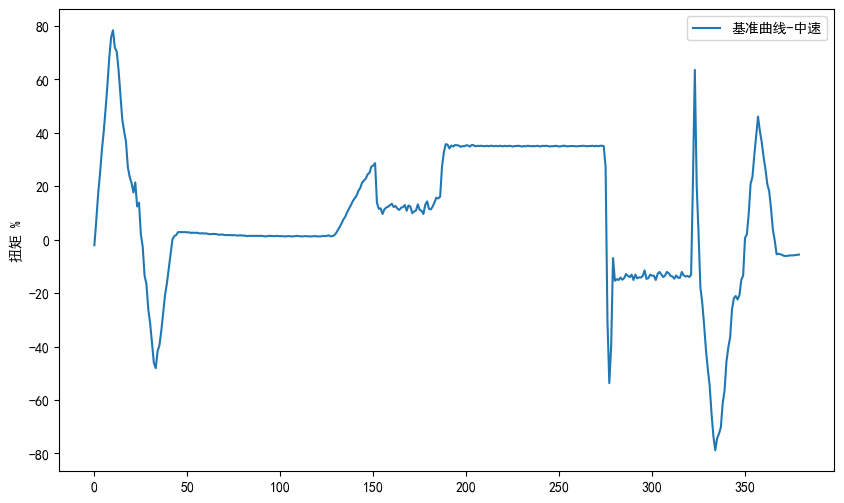

In [4]:
# 数据切分
res = get_startpoint(data)
# 可视化扭矩曲线
plt.figure(figsize=(10, 6))
plt.plot(range(len(res[2][3])), res[2][3], label='基准曲线-中速')
# plt.plot(range(len(res[3][3])),[res[2][3][i]-random.uniform(5,5.5) for i in range(len(res[2][3]))],label = '实时扭矩-中速')
plt.ylabel("扭矩 %")
plt.legend()

# fastdtw计算曲线相似度
DTW（动态时间规整）求曲线相似度的算法可以对时间进行对齐，更加注重y轴数值（扭矩）的影响，x轴（时间采样）对距离不敏感；  
这种求相似度的方法很好的满足了我们的需求，下面使用优化后的DTW库fastdtw对高，中，低三种速度进行测试；

## 测试数据

### 高速数据

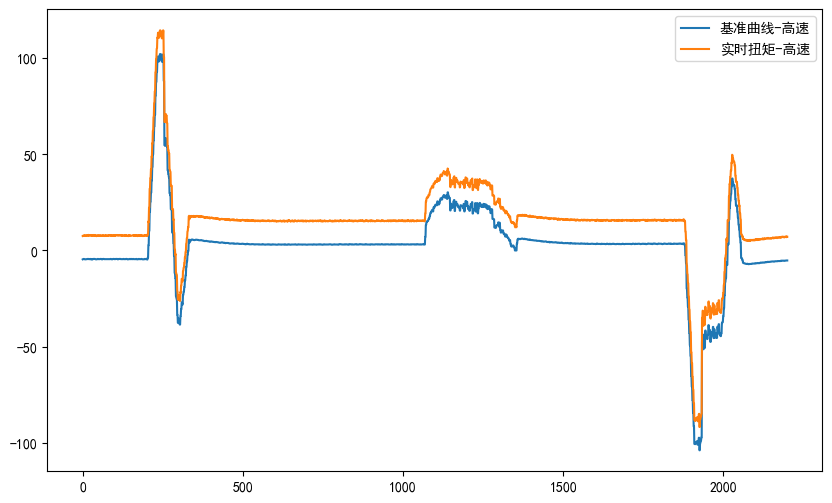

In [5]:
high_t = high_data['实时扭矩'][2300:4500]
plt.figure(figsize=(10,6))
plt.plot(range(len(high_t)),high_t,label = '基准曲线-高速')
plt.plot(range(len(high_t)),[i+random.uniform(12,12.5) for i in high_t],label = '实时扭矩-高速')
plt.legend()

### 中速数据

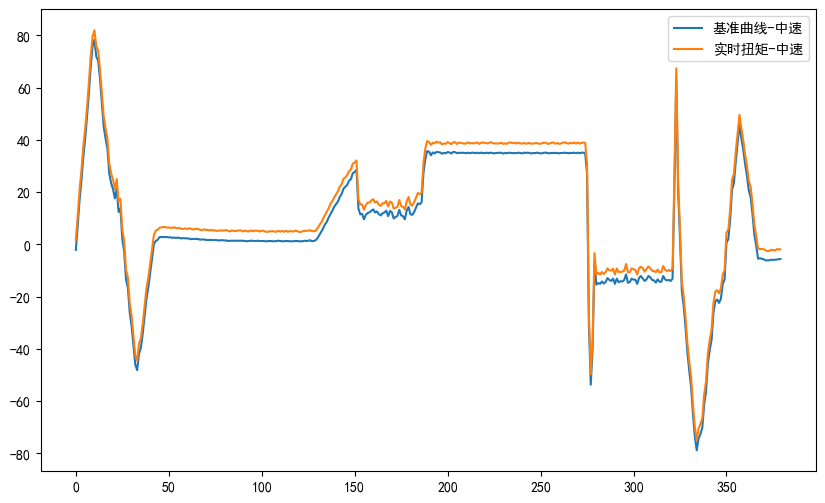

In [6]:
# 绘制中速扭矩曲线
plt.figure(figsize=(10,6))
plt.plot(range(len(res[2][3])),res[2][3],label = '基准曲线-中速')
plt.plot(range(len(res[2][3])),[i+random.uniform(3.5,4) for i in res[2][3]],label = '实时扭矩-中速')
plt.legend()
plt.show()

## fastdtw 实时输出相似度
注意：fastdtw 计算的是两条曲线的距离；距离越大，相似度越低；最后输出结果有必要对距离进行归一化，已输出相似度；

In [7]:
data1 = [[i,res[2][3][i]] for i in range(len(res[2][3]))]
data2 = [[i,res[3][3][i]] for i in range(len(res[3][3]))]
data3 = [[i,res[2][3][i]+random.uniform(1,1.5)] for i in range(len(res[2][3]))]
data4 = [[i,res[2][3][i]-random.uniform(5,5.5)] for i in range(len(res[2][3]))]
# data5 = [[i,data1[i][1]+10] for i in range(len(data1)) if i ==20 else data1[i]]
data5 = []
for i in range(len(data1)):
    if i == 20:
        data5.append([i,data1[i][1]+10])
    else:
        data5.append(data1[i])
data6 = [[i,0] for i in range(len(res[2][3]))]
        

In [8]:
# 计算基准曲线与实时曲线的相似度
def similarity_norm(base_data,real_data,zero_data):
    """
    base_data: 基准曲线
    real_data: 实时曲线
    zero_data: 0曲线，作为相似度0%的曲线
    
    similarity: 归一化后的相似度值
    """
    max_dist, path = fastdtw(base_data, zero_data, dist=euclidean)
    min_dist, path = fastdtw(base_data, base_data , dist=euclidean)
    real_dist,path = fastdtw(base_data, real_data , dist=euclidean)
#     print(max_dist,min_dist,real_dist)
    similarity = 1-(real_dist/(max_dist-min_dist))
    return similarity  

输出实时扭矩与基准曲线之前的相似度，我们希望的是相似度应该对**数值**敏感，对**采样时间**不敏感；  

### 数值变化

实时曲线相似度：67.72%


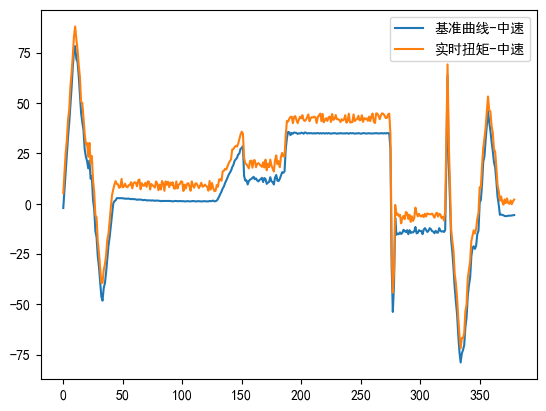

In [9]:
# 测试更改数值；
k = 2
data_ = [[i, res[k][3][i] + random.uniform(5, 10)]
         for i in range(len(res[k][3]))]
plt.plot(range(len(res[2][3])), res[2][3], label='基准曲线-中速')
plt.plot(range(len(data_)), [i[1] for i in data_], label='实时扭矩-中速')
plt.legend()
print("实时曲线相似度：" + str(round(similarity_norm(data1, data_, data6) * 100, 2)) +
      '%')
plt.show()

### 采样时间变化

实时曲线相似度：98.38%


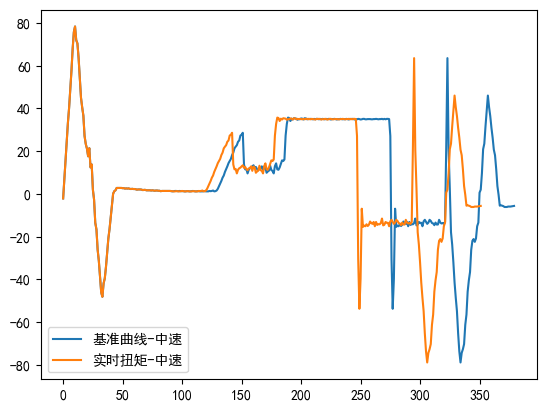

In [10]:
# 测试更改采样时间点

k = 2
data_s = [[i, res[k][3][i]] for i in range(len(res[k][3]))]
data_ = []
for i in range(len(data_s)):
    if i <= 90 or 100 <= i <= 220 or i >= 240:
        data_.append(data_s[i])
plt.plot(range(len(res[2][3])), res[2][3], label='基准曲线-中速')
plt.plot(range(len(data_)), [i[1] for i in data_], label='实时扭矩-中速')
plt.legend()
print("实时曲线相似度：" + str(round(similarity_norm(data1, data_, data6) * 100, 2)) +
      '%')
plt.show()

## 结论
1. 从上述两个实例可以看出，当采样时间长短变化时，曲线的相似度仍然很高；但是当扭矩数值变化时，曲线的相似度就变得较低；
2. fastdtw算法优化了dtw算法，可以看到执行时间基本都是ms级，效率也不错;